# DataJoint Elements for Electrode Localization

#### Open-source data pipeline for localizing Neuropixels electrodes within the Allen brain atlas - [Allen Mouse Common Coordinate Framework (CCF)](https://atlas.brain-map.org/)

Welcome to the tutorial for the DataJoint Element for electrode localization. This tutorial aims to provide a comprehensive understanding of the open-source data pipeline created using `element-electrode-localization`.

![flowchart](../images/flowchart.svg)

This package is designed to seamlessly ingest and track **electrode localization** data using DataJoint. 

![flowchart](../images/pipeline.svg)

By the end of this tutorial, you will have a clear grasp on setting up  `element-electrode-localization` into your specific research projects and lab.

### Prerequisites
Please see the [datajoint tutorials GitHub repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before proceeding.

#### **Tutorial Overview**
+ Setup
+ *Activate* the DataJoint pipeline.
+ *Insert* example data into subject and session tables.
+ *Description* of the main tables.

### **Setup**
This tutorial describes the DataJoint tables that track the electrode localization data acquired with Neuropixels probes. The goal is to store, track, and manage all metadata associated with electrode localization and position probes, aligning to the Common Coordinate Framework (CCF) space within the Allen brain atlas.

The results of this Element can be combined with **other modalities** to create a complete, customizable data pipeline for your specific lab or study. For instance, you can combine `element-electrode-localization` with `element-array-ephys` and `element-event` to characterize the neural activity during specific stimulus events.

Let's start this tutorial by importing the packages necessary to run the notebook.

In [1]:
import datajoint as dj
from pathlib import Path
import yaml

If the tutorial is run in Codespaces, a private, local database server is created and made available for you. This is where we will insert and store our processed results. Let's connect to the database server.

In [2]:
dj.conn()

[2024-01-26 23:16:36,794][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-01-26 23:16:36,802][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

This tutorial presumes that the `element-electrode-localization` has been pre-configured and instantiated, with the database linked downstream to pre-existing `subject` and `session` tables. Please refer to the [`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code.

Now, we will proceed to import the schemas required to construct this data pipeline. 

**Please note:** This step may take a few minutes because it populates some of the tables in the `coordinate_framework` schema. 

In [3]:
from tutorial_pipeline import (
    subject,
    session,
    probe,
    ephys,
    electrode_localization,
    coordinate_framework as ccf,
)

[2024-01-26 23:16:37,885][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2024-01-26 23:16:58,660][INFO]: .. loaded atlas brain volume of shape (132, 80, 114) from /workspaces/element-electrode-localization/example_data/annotation_100.nrrd
0it [00:00, ?it/s][2024-01-26 23:16:58,968][INFO]: .. loading region 0 (0/1327) (root)
[2024-01-26 23:16:58,995][INFO]: .. region 0 volume: shape (698481, 3)
1it [01:18, 78.01s/it][2024-01-26 23:18:16,977][INFO]: .. loading region 1 (1/1327) (Basic cell groups and regions)
[2024-01-26 23:18:16,989][INFO]: .. region 1 volume: shape (107, 3)
2it [01:18, 32.18s/it][2024-01-26 23:18:17,078][INFO]: .. loading region 2 (2/1327) (Cerebrum)
[2024-01-26 23:18:17,083][INFO]: .. region 2 volume: shape (119, 3)
[2024-01-26 23:18:17,111][INFO]: .. loading region 3 (3/1327) (Cerebral cortex)
[2024-01-26 23:18:17,117][INFO]: .. region 3 volume: shape (0, 3) - skipping
[2024-01-26 23:18:17,

We can represent the tables in the `electrode-localization` and `coordinate_framework`schemas as well as some of the upstream dependencies to `session` and `subject` schemas as a diagram.


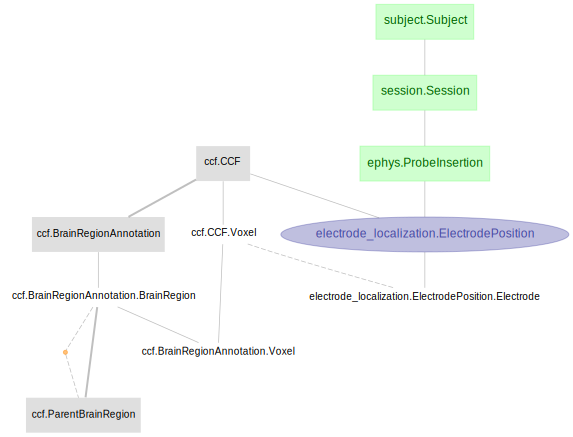

In [4]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(electrode_localization)
    + dj.Diagram(ccf)
)

As evident from the diagram, this data pipeline encompasses tables associated with electrode localization data. A few tables, such as `subject.Subject` and `session.Session`, while important for a complete pipeline, fall outside the scope of the `element-electrode-localization` tutorial, and will therefore, not be explored extensively here. The primary focus of this tutorial will be on the `coordinate_framework` and `electrode-localization` schemas.

### **Inspect and Query Coordinate Framework Tables**

The Allen Institute hosts [brain atlases](http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/) and [ontology trees](https://community.brain-map.org/t/allen-mouse-ccf-accessing-and-using-related-data-and-tools/359) that we'll use in the next section. The `tutorial_pipeline.py` script assumes this is your first atlas, and that you'll use the 100μm resolution. Let's explore the data that was loaded into the `coordinate_framework` schema.

In [5]:
ccf.BrainRegionAnnotation.BrainRegion()

"ccf_id CCF ID, a.k.a atlas ID",acronym CHARACTER SET utf8 COLLATE utf8_bin,region_name,region_id,color_code Hex code of the color code of this region
0,6b,Layer 6b isocortex,16,8ADA87
0,a_a_a,Anterior amygdalar area,23,80C0E2
0,a_c_a,Anterior cingulate area,31,40A666
0,a_c_a1,Anterior cingulate area layer 1,572,40A666
0,a_c_a2/3,Anterior cingulate area layer 2/3,1053,40A666
0,a_c_a5,Anterior cingulate area layer 5,739,40A666
0,a_c_a6a,Anterior cingulate area layer 6a,179,40A666
0,a_c_a6b,Anterior cingulate area layer 6b,227,40A666
0,a_c_ad,Anterior cingulate area dorsal part,39,40A666
0,a_c_ad1,Anterior cingulate area dorsal part layer 1,935,40A666



The acronyms listed in the DataJoint table differ slightly from the CCF standard by substituting case-sensitive differences with [snake case](https://en.wikipedia.org/wiki/Snake_case). To lookup the snake case equivalent, use the `retrieve_acronym` function.

In [6]:
central_thalamus = ccf.BrainRegionAnnotation.retrieve_acronym("CM")
cranial_nerves = ccf.BrainRegionAnnotation.retrieve_acronym("cm")
print(f"CM: {central_thalamus}\ncm: {cranial_nerves}")

CM: c_m
cm: cm


In [7]:
cm_voxels = ccf.BrainRegionAnnotation.Voxel() & f"acronym='{central_thalamus}'"
cm_voxels

"ccf_id CCF ID, a.k.a atlas ID",acronym CHARACTER SET utf8 COLLATE utf8_bin,x (um) Anterior-to-Posterior (AP axis),y (um) Superior-to-Inferior (DV axis),z (um) Left-to-Right (ML axis)
0,c_m,100,3300,4900
0,c_m,100,3300,5000
0,c_m,100,3300,5100
0,c_m,100,3300,5200
0,c_m,100,3300,5300
0,c_m,100,3300,6100
0,c_m,100,3300,6200
0,c_m,100,3300,6300
0,c_m,100,3300,6400
0,c_m,100,3300,6500


In [8]:
cm_x, cm_y, cm_z = cm_voxels.fetch("x", "y", "z")
print(
    f"The central thalamus extends from \n\tx = {min(cm_x)}  to x = {max(cm_x)}\n\t"
    + f"y = {min(cm_y)} to y = {max(cm_y)}\n\tz = {min(cm_z)} to z = {max(cm_z)}"
)

The central thalamus extends from 
	x = 100  to x = 8400
	y = 2600 to y = 7500
	z = 1700 to z = 9700


### **Electrode Localization**
Now, let's delve into the `subject.Subject` and `session.Session` tables and include some example data.

In [9]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description


Add a new entry for a subject in the `Subject` table:

In [10]:
subject.Subject.insert1(
    dict(subject="subject5", subject_birth_date="2023-01-01", sex="U")
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject5,,U,2023-01-01,


Create session keys and input them into the `Session` table:

In [11]:
session_key = dict(subject="subject5", session_datetime="2023-01-01 00:00:00")
session.Session.insert1(session_key)
session.Session()

subject,session_datetime,session_id
subject5,2023-01-01 00:00:00,None


In [12]:
session.SessionDirectory.insert1(
    dict(**session_key, session_dir="raw/subject5/session1")
)
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject5,2023-01-01 00:00:00,raw/subject5/session1


In [13]:
probe.Probe.insert1(
    dict(probe="714000838", probe_type="neuropixels 1.0 - 3B")
)  # this info could be achieve from neuropixels meta file.
probe.Probe()

probe unique identifier for this model of probe (e.g. serial number),probe_type e.g. neuropixels_1.0,probe_comment
714000838,neuropixels 1.0 - 3B,


In [14]:
ephys.ProbeInsertion.heading

# Probe insertion implanted into an animal for a given session.
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
---
probe                : varchar(32)                  # unique identifier for this model of probe (e.g. serial number)

In [15]:
ephys.ProbeInsertion.insert1(
    dict(
        session_key,
        insertion_number=1,
        probe="714000838",
    )
)  # probe, subject, session_datetime needs to follow the restrictions of foreign keys.
ephys.ProbeInsertion()

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
subject5,2023-01-01 00:00:00,1,714000838


In [16]:
ephys.EphysRecording.populate()

In [18]:
%pdb on

Automatic pdb calling has been turned ON


In [21]:
electrode_localization.ElectrodePosition.populate()

KeyError: (16.0, 0.0)

> /workspaces/element-electrode-localization/element_electrode_localization/electrode_localization.py(259)<listcomp>()
    257 
    258             rec_to_elec_idx = np.array(
--> 259                 [elec_coord_map[tuple(i)] for i in rec_electrodes]
    260             )
    261 

> /workspaces/element-electrode-localization/element_electrode_localization/electrode_localization.py(259)make()
    257 
    258             rec_to_elec_idx = np.array(
--> 259                 [elec_coord_map[tuple(i)] for i in rec_electrodes]
    260             )
    261 

{(27.0, 0.0): 0, (59.0, 0.0): 1, (11.0, 20.0): 2, (43.0, 20.0): 3, (27.0, 40.0): 4, (59.0, 40.0): 5, (11.0, 60.0): 6, (43.0, 60.0): 7, (27.0, 80.0): 8, (59.0, 80.0): 9, (11.0, 100.0): 10, (43.0, 100.0): 11, (27.0, 120.0): 12, (59.0, 120.0): 13, (11.0, 140.0): 14, (43.0, 140.0): 15, (27.0, 160.0): 16, (59.0, 160.0): 17, (11.0, 180.0): 18, (43.0, 180.0): 19, (27.0, 200.0): 20, (59.0, 200.0): 21, (11.0, 220.0): 22, (43.0, 220.0): 23, (27.0

In [ ]:
ccf.CCF.fetch1("KEY")

In [ ]:
ephys.ProbeInsertion.fetch1("KEY")

In [ ]:
ephys.EphysRecording.populate(session_key)

In [ ]:
ccf.CCF.fetch1("ccf_resolution")

In [ ]:
from tutorial_pipeline import get_electrode_localization_dir

### **Description of the main tables**

To know what data to insert into the table, we can view its dependencies and attributes using the `.heading` method. `heading` provides an exhaustive list of the table's attributes. This list includes both the attributes declared in this table and any inherited from upstream tables.

`ProbeInsertion` table will contain the data for probe insertion implanted into an animal for a given session. Let's insert some example data into the `ProbeInsertion` table as well:

In [ ]:
ccf.BrainRegionAnnotation.BrainRegion()

In [ ]:
central_thalamus = ccf.BrainRegionAnnotation.retrieve_acronym("CM")
cranial_nerves = ccf.BrainRegionAnnotation.retrieve_acronym("cm")
print(f"CM: {central_thalamus}\ncm: {cranial_nerves}")

In [ ]:
electrode_localization.ProbeInsertion.heading

`ElectrodePosition` table computes the electrode position information for a probe insertion.    

In [ ]:
electrode_localization.ElectrodePosition.heading

### Summary

Following this tutorial, we have:

- Covered the essential description of `element-electrode-localization`
- Learned how to manually insert data into tables

#### Documentation and DataJoint tutorials

+ Detailed [documentation on `element-electrode-localization`](https://datajoint.com/docs/elements/element-electrode-localization/0.1/)
+  [General `DataJoint-Python` interactive tutorials](https://github.com/datajoint/datajoint-tutorials), covering fundamentals, such as table tiers, query operations, fetch operations, automated computations with the make function, and more.
+ [Documentation for `DataJoint-Python`](https://datajoint.com/docs/core/datajoint-python/0.14/)